In [1]:
from dataclasses import dataclass
from typing import Dict, List, Union

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import pymc3.math as pmm

from scipy.stats import bernoulli, expon

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.2


In [2]:
RANDOM_SEED = 242
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

This notebook demonstrates how to implement a Bayesian analysis of an A/B test. We implement the models discussed in VWO's [Bayesian A/B Testing Whitepaper](https://vwo.com/downloads/VWO_SmartStats_technical_whitepaper.pdf), and discuss the effect of different prior choices for these models. This notebook does _not_ discuss other related topics like how to choose a prior, early stopping, and power analysis.

#### What is A/B testing?

From https://vwo.com/ab-testing/:

> A/B testing (also known as split testing) is a process of showing two variants of the same web page to different segments of website visitors at the same time and comparing which variant drives more conversions.

Specifically, A/B tests are often used in the software industry to find the whether a new feature or change should be released to its users, and its impact on core product metrics ("conversions"). Furthermore:

* We can show more than two variants at the same time. We'll be dealing with how to analyse these tests in this notebook as well.
* Exactly what "conversions" means can vary between tests, but two classes of conversions we'll focus on are:
  * Bernoulli conversions - a flag for whether the visitor did the target action or not (e.g. completed at least one purchase).
  * Value conversions - a real value per visitor (e.g. the dollar revenue, which could also be 0).
 
If you've studied [controlled experiments](https://www.khanacademy.org/science/high-school-biology/hs-biology-foundations/hs-biology-and-the-scientific-method/a/experiments-and-observations) in the context of biology, psychology, and other sciences before, the description above sounds a lot like a controlled experiment - and that's because it is! The concept of a control group and treatment groups, and the principles of experimental design, are the building blocks of A/B testing. The main difference is the context of the experiment: A/B tests are typically run by online software companies, where the subjects are visitors to the website / app, the outcomes of interest are behaviours that can be tracked like signing up, purchasing a product, and returning to the website.

A/B tests are typically analysed with traditional hypothesis tests (see [t-test](https://en.wikipedia.org/wiki/Student%27s_t-test)), but another method is to use Bayesian statistics. This allows us to incorporate prior distributions and produce a range of outcomes to the questions "is there a winning variant?" and "by how much?".

### Bernoulli Conversions

Let's first deal with a simple two-variant A/B test, where the metric of interest is the proportion of users performing an action (e.g. purchase at least one item), a bernoulli conversion. Our variants are called A and B, where A refers to the existing landing page and B refers to the new page we want to test. The outcome that we're doing inference on here is whether B is "better" than A, which is depends on the underlying "true" conversion rates for each variant. We can formulate this as follows:

Let $\theta_A, \theta_B$ be the true conversion rates for variants A and B respectively. Then the outcome of whether a visitor converts in variant A is the random variable $\mathrm{Bernoulli}(\theta_A)$, and $\mathrm{Bernoulli}(\theta_B)$ for variant B. If we assume that visitors' behaviour on the landing page is independent of other visitors (a fair assumption), then the total conversions $y$ for a variant has the Binomial distribution:

$$y \sim \sum^N\mathrm{Bernoulli}(\theta) = \mathrm{Binomial}(N, \theta)$$

Under a Bayesian framework, we assume the true conversion rates $\theta_A, \theta_B$ cannot be known, and instead they each follow a Beta distribution. The underlying rates are assumed to be independent, since we're splitting out traffic randomly, so the behaviour of one variant would not affect the other: 

$$\theta_A \sim \theta_B \sim \mathrm{Beta}(\alpha, \beta)$$

Now we have our observed data for the duration of the A/B test (the likelihoood distribution): the number of visitors landing on the page `N`, and the number of visitors purchasing at least one item `y`:

$$y_A \sim \mathrm{Binomial}(n = N_A, p = \theta_A), y_B \sim \mathrm{Binomial}(n = N_B, p = \theta_B)$$

With this, we can sample from the joint posterior of $\theta_A, \theta_B$. 

You may have noticed that the Beta distribution is the conjugate prior for the Binomial, so we don't need MCMC sampling to estimate the posterior (the exact solution can be found in the VWO paper). We'll still demonstrate how sampling can be done with PyMC3 though, and doing this makes it easier to extend the model with different priors, dependency assumptions, etc.

Finally, remember that our outcome of interest is whether B is better than A. A common measure in practice for whether B is better than is the _relative uplift in conversion rates_, i.e. the percentage difference of $\theta_B$ over $\theta_A$:

$$\mathrm{reluplift}_B = \theta_B / \theta_A - 1$$

We'll implement this model setup in PyMC3 below.

In [3]:
@dataclass
class BetaPrior:
    alpha: float
    beta: float

In [4]:
@dataclass
class BinomialData:
    trials: int
    successes: int

In [5]:
class ConversionModelTwoVariant:
    def __init__(self, priors: BetaPrior):
        self.priors = priors

    def create_model(self, data: List[BinomialData]) -> pm.Model:
        trials = [d.trials for d in data]
        successes = [d.successes for d in data]
        with pm.Model() as model:
            p = pm.Beta("p", alpha=self.priors.alpha, beta=self.priors.beta, shape=2)
            obs = pm.Binomial("y", n=trials, p=p, shape=2, observed=successes)
            reluplift = pm.Deterministic("reluplift_b", p[1] / p[0] - 1)
        return model

Now that we've defined a class that can take a prior and our synthetic data as inputs, our first step is to choose an appropriate prior. There are a few things to consider when doing this in practice, but for the purpose of this notebook we'll focus on the following things:

* We assume that the same Beta prior is set for all variants.
* An _uninformative_ or _weakly informative_ prior occurs when we set low values for `alpha` and `beta`. For example, `alpha = 1, beta = 1` leads to a uniform distribution as a prior. If we were considering one distribution in isolation, setting this prior is a statement that we don't know anything about the value of the parameter, nor our confidence around it. In the context of A/B testing however, we're interested in comparing the _relative uplift_ of one variant over another. With a weakly informative Beta prior, this relative uplift distribution is very wide, so we're implicitly saying that the variants could be very different to each other.
* A _strong_ prior occurs when we set high values for `alpha` and `beta`. Contrary to the above, a strong prior would imply that the relative uplift distribution is thin, i.e. our prior belief is that the variants are not very different from each other.

We illustrate these points with prior predictive checks.

#### Prior predictive checks

Note that we can pass in arbitrary values for the observed data in these prior predictive checks. PyMC3 will not use that data when sampling from the prior predictive distribution.

In [6]:
weak_prior = ConversionModelTwoVariant(BetaPrior(alpha=100, beta=100))

In [7]:
strong_prior = ConversionModelTwoVariant(BetaPrior(alpha=10000, beta=10000))

In [8]:
with weak_prior.create_model(data=[BinomialData(1, 1), BinomialData(1, 1)]):
    weak_prior_predictive = pm.sample_prior_predictive(samples=10000)

In [9]:
with strong_prior.create_model(data=[BinomialData(1, 1), BinomialData(1, 1)]):
    strong_prior_predictive = pm.sample_prior_predictive(samples=10000)

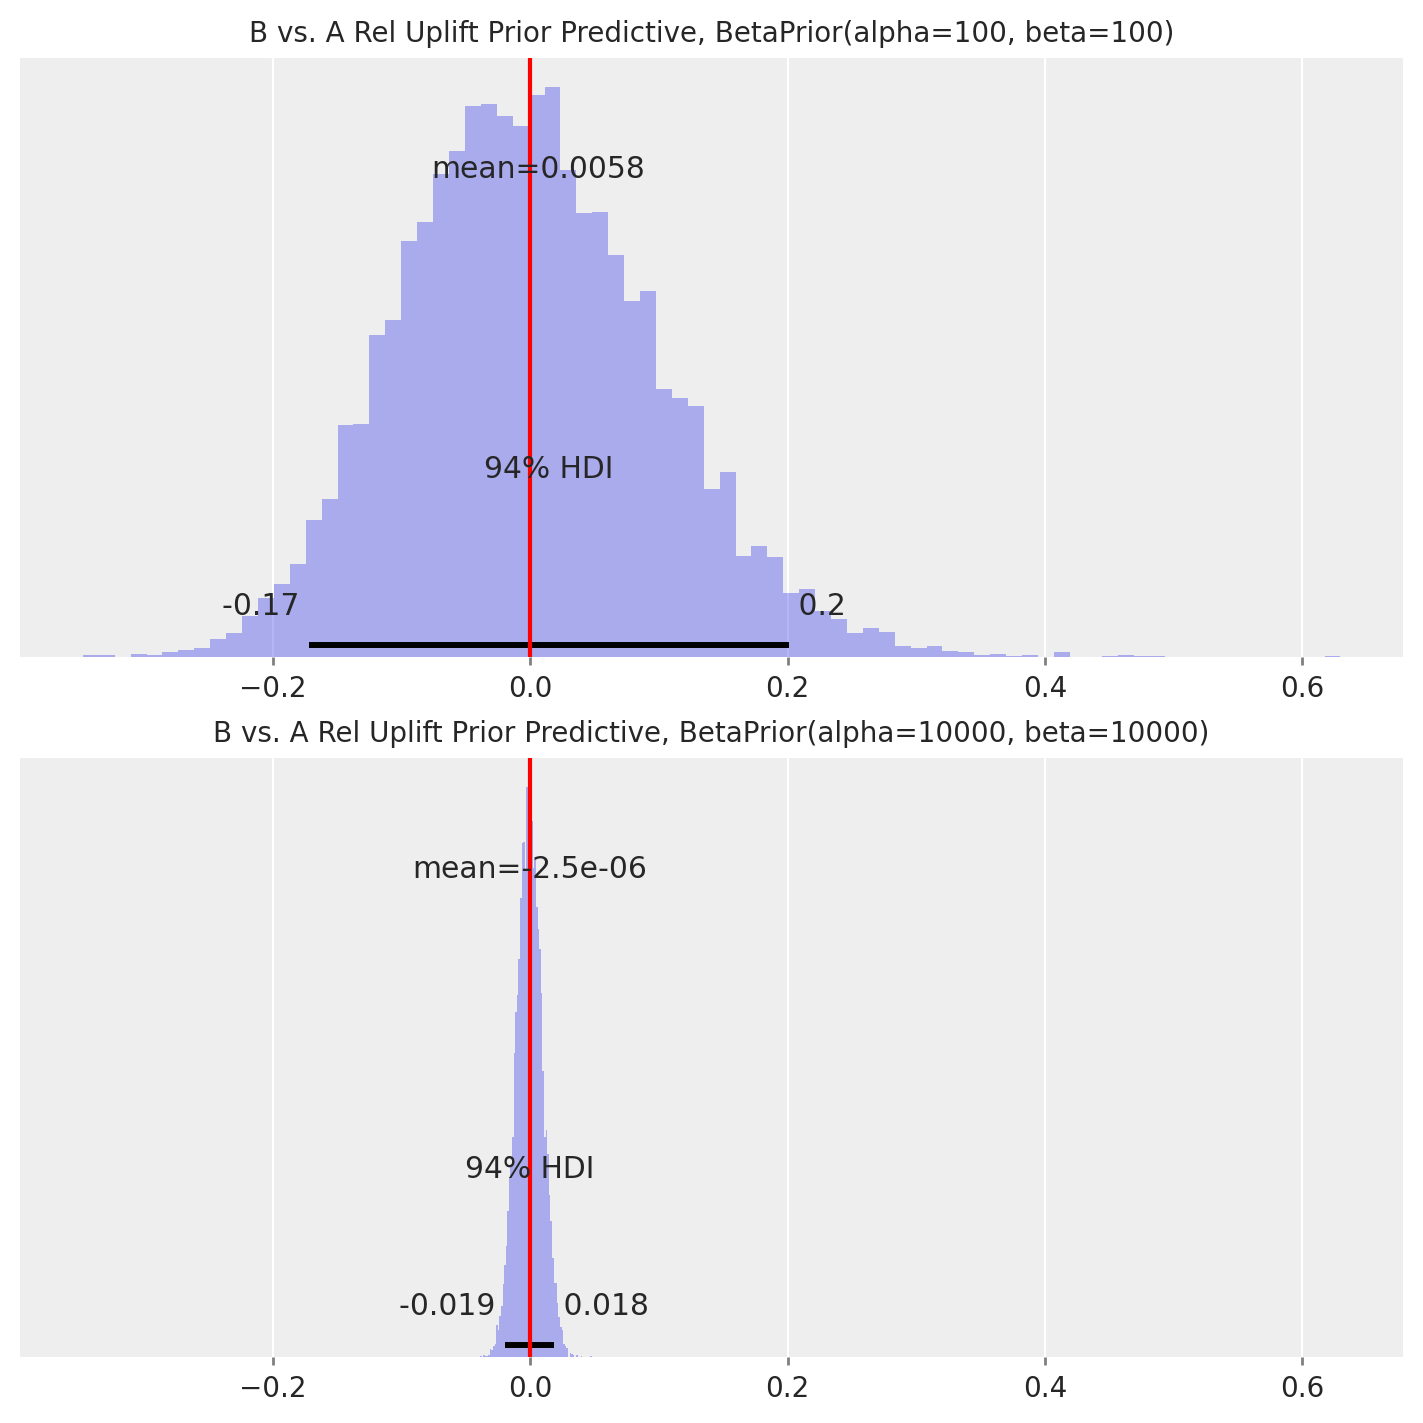

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
az.plot_posterior(weak_prior_predictive["reluplift_b"], textsize=10, ax=axs[0], kind="hist")
axs[0].set_title(f"B vs. A Rel Uplift Prior Predictive, {weak_prior.priors}", fontsize=10)
axs[0].axvline(x=0, color="red")
az.plot_posterior(strong_prior_predictive["reluplift_b"], textsize=10, ax=axs[1], kind="hist")
axs[1].set_title(f"B vs. A Rel Uplift Prior Predictive, {strong_prior.priors}", fontsize=10)
axs[1].axvline(x=0, color="red")

With the weak prior our 94% HDI for the relative uplift for B over A is roughly [-20%, +20%], whereas it is roughly [-2%, +2%] with the strong prior. This is effectively the "starting point" for the relative uplift distribution, and will affect how the observed conversions translate to the posterior distribution.

How we choose these priors in practice depends on broader context of the company running the A/B tests. A strong prior can help guard against false discoveries, but may require more data to detect winning variants when they exist (and more data = more time required running the test). A weak prior gives more weight to the observed data, but could also lead to more false discoveries as a result of early stopping issues.

Below we'll walk through the inference results from two different prior choices.

#### Data

Next we'll try passing synthetic data into the model. We generate two datasets: one where the "true" conversion rate of each variant is the same, and one where variant B has a higher true conversion rate.

In [11]:
def generate_binomial_data(
    variants: List[str], true_rates: List[str], samples_per_variant: int = 100000
) -> pd.DataFrame:
    data = {}
    for variant, p in zip(variants, true_rates):
        data[variant] = bernoulli.rvs(p, size=samples_per_variant)
    agg = (
        pd.DataFrame(data)
        .aggregate(["count", "sum"])
        .rename(index={"count": "trials", "sum": "successes"})
    )
    return agg

In [12]:
# Example generated data
generate_binomial_data(["A", "B"], [0.23, 0.23])

,A,B
trials,100000,100000
successes,22990,23294


We'll also write a function to wrap the data generation, sampling, and posterior plots so that we can easily compare the results of both models (strong and weak prior) under both scenarios (same true rate vs. different true rate).

In [13]:
def run_scenario_twovariant(
    variants: List[str],
    true_rates: List[float],
    samples_per_variant: int,
    weak_prior: BetaPrior,
    strong_prior: BetaPrior,
) -> None:
    generated = generate_binomial_data(variants, true_rates, samples_per_variant)
    data = [BinomialData(**generated[v].to_dict()) for v in variants]
    with ConversionModelTwoVariant(priors=weak_prior).create_model(data):
        trace_weak = pm.sample(draws=5000, return_inferencedata=True, cores=1, chains=2)
    with ConversionModelTwoVariant(priors=strong_prior).create_model(data):
        trace_strong = pm.sample(draws=5000, return_inferencedata=True, cores=1, chains=2)

    true_rel_uplift = true_rates[1] / true_rates[0] - 1

    fig, axs = plt.subplots(2, 1, figsize=(7, 7), sharex=True)
    az.plot_posterior(trace_weak.posterior["reluplift_b"], textsize=10, ax=axs[0], kind="hist")
    axs[0].set_title(f"True Rel Uplift = {true_rel_uplift:.1%}, {weak_prior}", fontsize=10)
    axs[0].axvline(x=0, color="red")
    az.plot_posterior(trace_strong.posterior["reluplift_b"], textsize=10, ax=axs[1], kind="hist")
    axs[1].set_title(f"True Rel Uplift = {true_rel_uplift:.1%}, {strong_prior}", fontsize=10)
    axs[1].axvline(x=0, color="red")
    fig.suptitle("B vs. A Rel Uplift")

#### Scenario 1 - same underlying conversion rates

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 4 seconds.


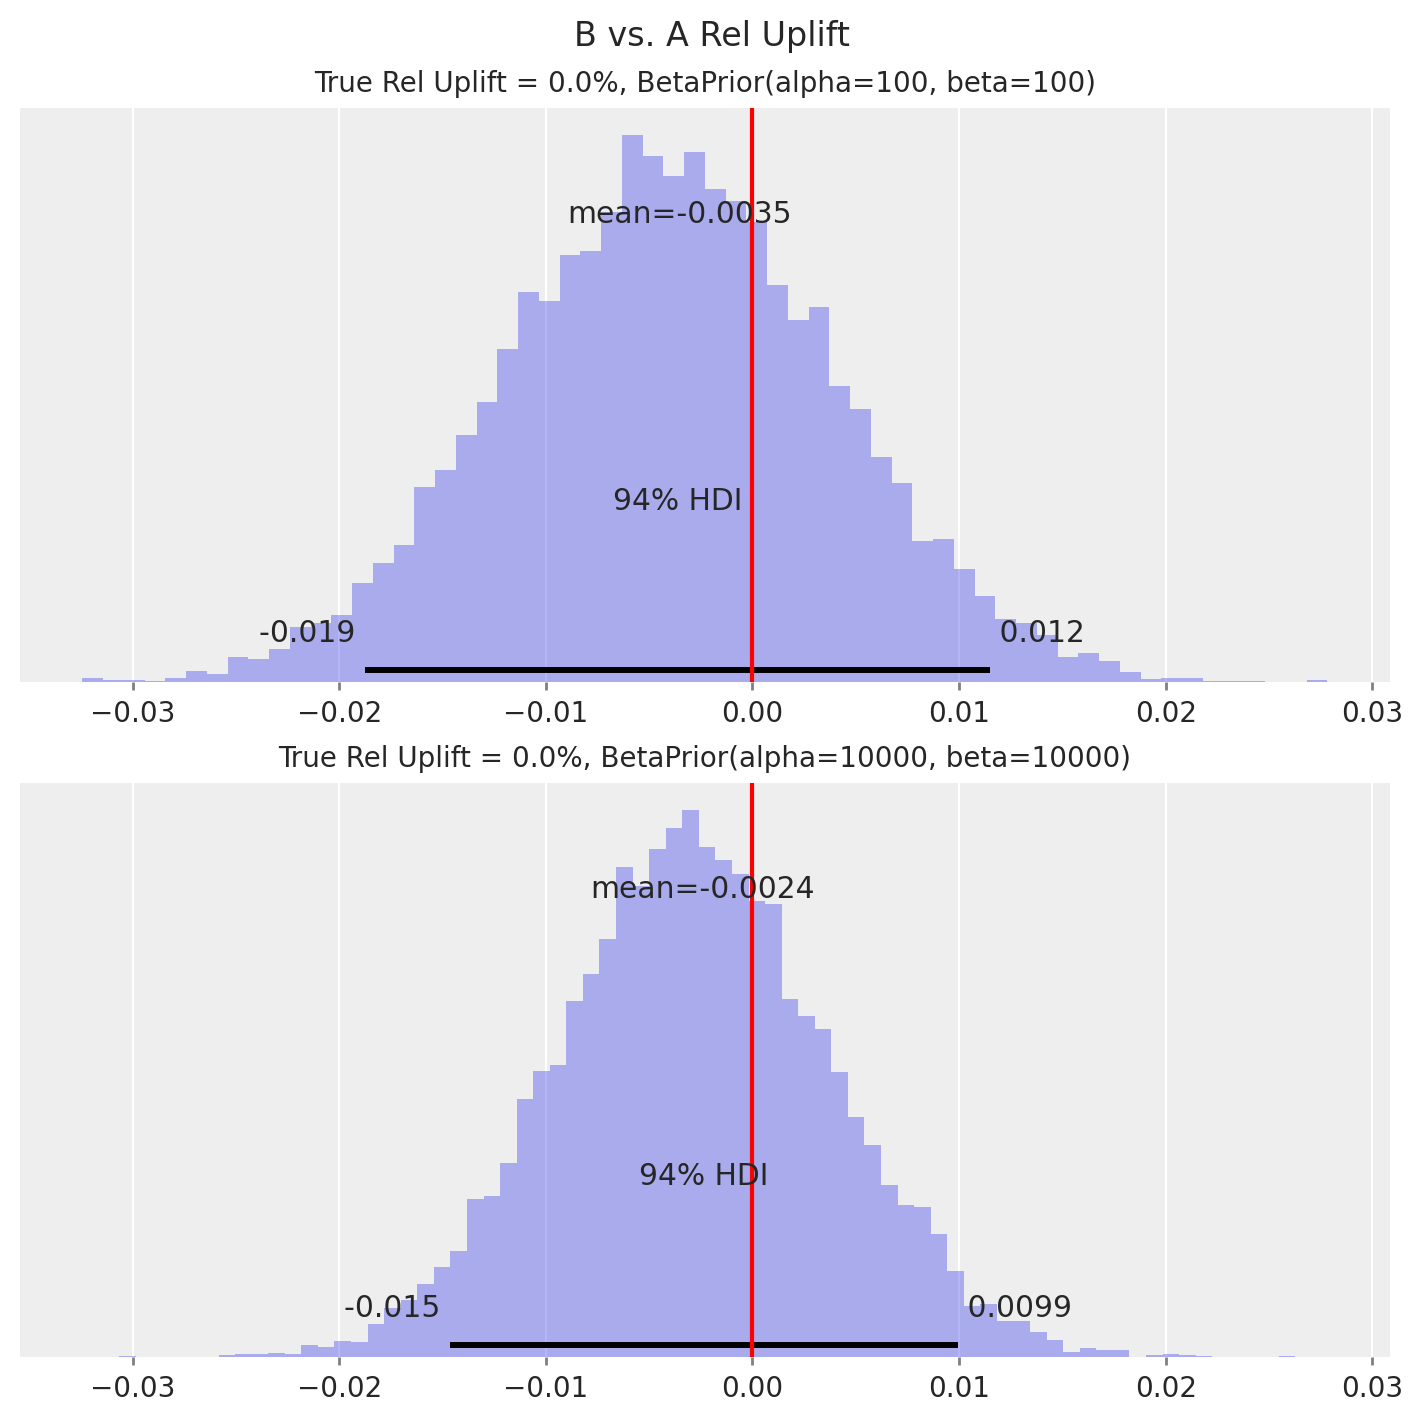

In [14]:
run_scenario_twovariant(
    variants=["A", "B"],
    true_rates=[0.23, 0.23],
    samples_per_variant=100000,
    weak_prior=BetaPrior(alpha=100, beta=100),
    strong_prior=BetaPrior(alpha=10000, beta=10000),
)

* In both cases, the true uplift of 0% lies within the 94% HDI.
* We can then use this relative uplift distribution to make a decision about whether to apply the new landing page / features in Variant B as the default. For example, we can decide that if the 94% HDI is above 0, we would roll out Variant B. In this case, 0 is in the HDI, so the decision would be to _not_ roll out Variant B.

#### Scenario 2 - different underlying rates

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 5 seconds.


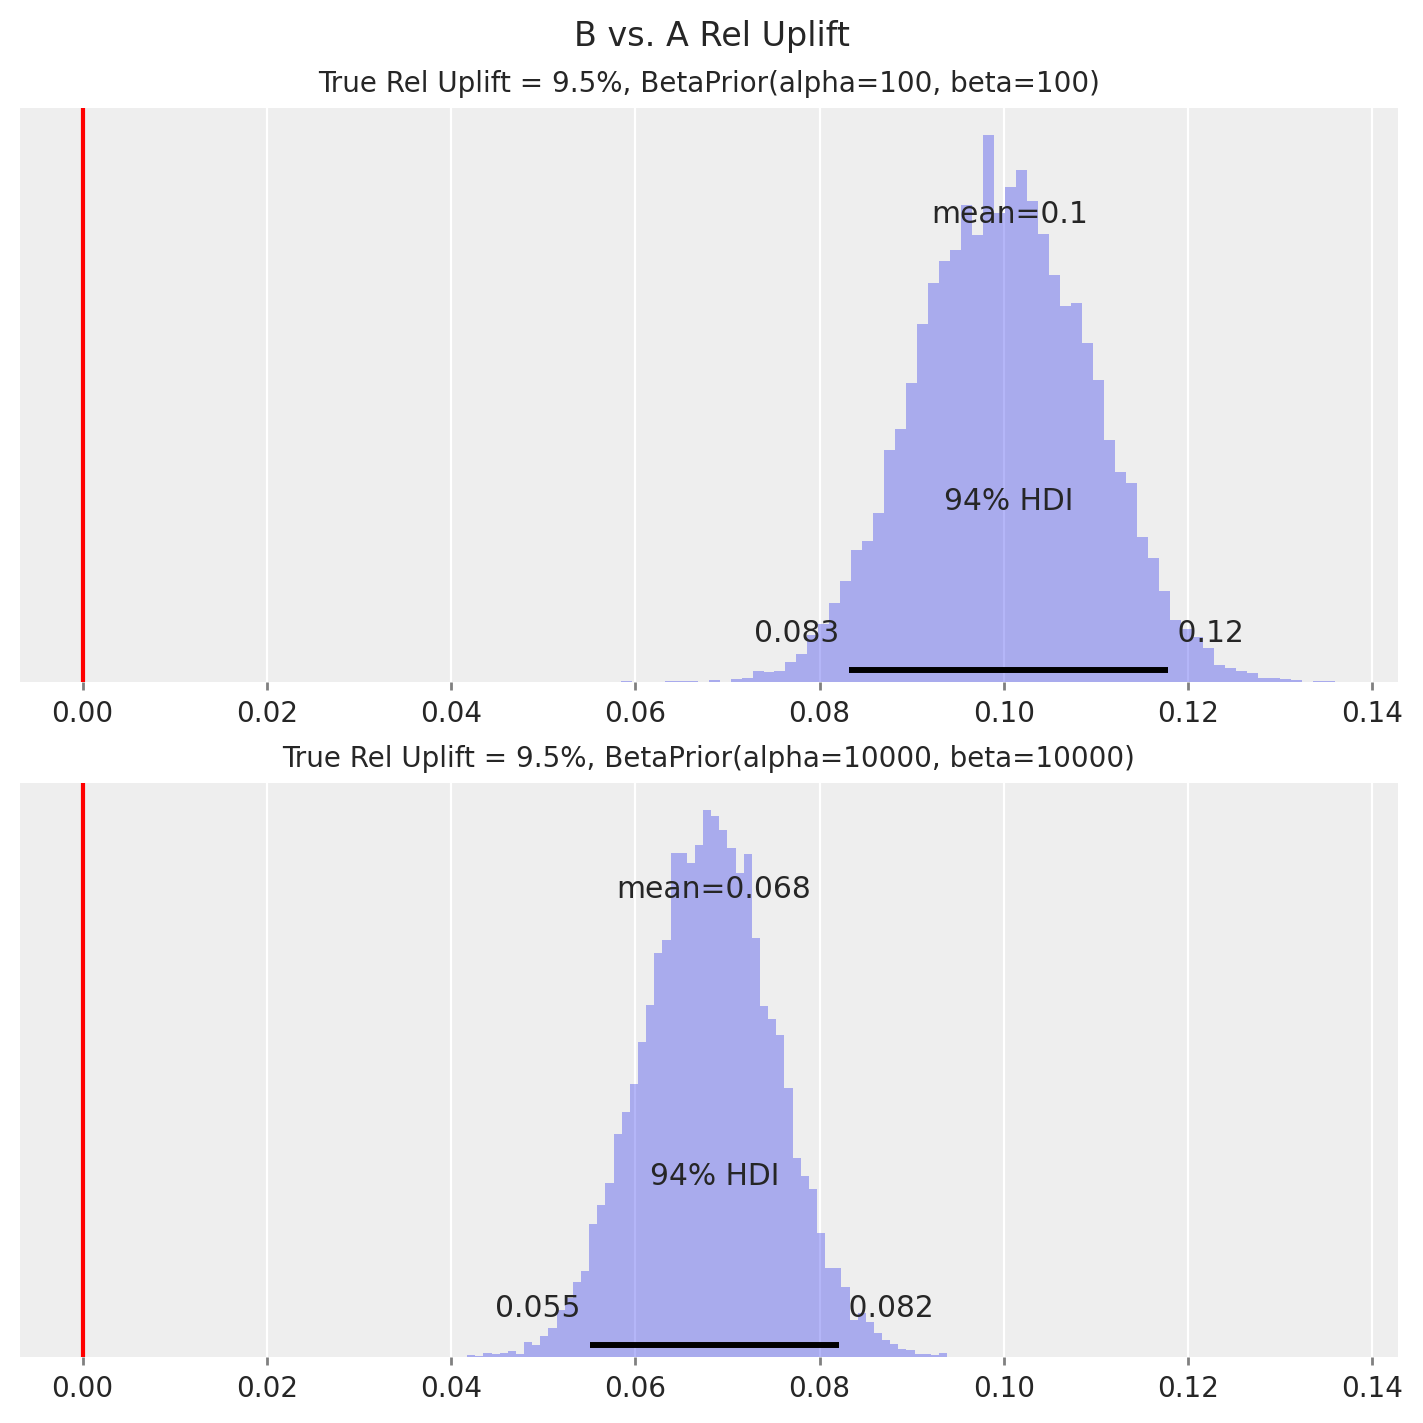

In [15]:
run_scenario_twovariant(
    variants=["A", "B"],
    true_rates=[0.21, 0.23],
    samples_per_variant=100000,
    weak_prior=BetaPrior(alpha=100, beta=100),
    strong_prior=BetaPrior(alpha=10000, beta=10000),
)

* In both cases, the posterior relative uplift distribution suggests that B has a higher conversion rate than A, as the 94% HDI is well above 0. The decision in this case would be to roll out Variant B to all users, and this outcome "true discovery".
* That said, in practice are usually also interested in _how much better_ Variant B is. For the model with the strong prior, the prior outweighs the observed data, so our central estimate of the relative uplift is **conservative (i.e. understated)**. We would need much more data for our inference to get closer to the true relative uplift of 9.5%.

The above examples demonstrate how to calculate perform A/B testing analysis for a two-variant test with the simple Beta-Binomial model, and the benefits and disadvantages of choosing a weak vs. strong prior. In the next section we provide a guide for handling a multi-variant ("A/B/n") test.

### Generalising to multi-variant tests 

We'll continue using Bernoulli conversions and the Beta-Binomial model in this section for simplicity. The focus is on how to analyse tests with 3 or more variants - e.g. instead of just having one different landing page to test, we have multiple ideas we want to test at once. How can we tell if there's a winner amongst all of them?

There are two main approaches we can take here:

1. Take A as the 'control'. Compare the other variants (B, C, etc.) against A, one at a time.
2. For each variant, compare against the `max()` of the other variants.

Approach 1 is intuitive to most people, and is easily explained. But what if there are two variants that both beat the control, and we want to know which one is better? We can't make that inference with the individual uplift distributions. Approach 2 does handle this case - it effectively tries to find whether there is a clear winner or clear loser(s) amongst all the variants.

We'll implement the model setup for both approaches below, cleaning up our code from before so that it generalises to the `n` variant case. Note that we can also re-use this model for the 2-variant case.

In [16]:
class ConversionModel:
    def __init__(self, priors: BetaPrior):
        self.priors = priors

    def create_model(self, data: List[BinomialData], comparison_method) -> pm.Model:
        num_variants = len(data)
        trials = [d.trials for d in data]
        successes = [d.successes for d in data]
        with pm.Model() as model:
            p = pm.Beta("p", alpha=self.priors.alpha, beta=self.priors.beta, shape=num_variants)
            y = pm.Binomial("y", n=trials, p=p, observed=successes, shape=num_variants)
            reluplift = []
            for i in range(num_variants):
                if comparison_method == "compare_to_control":
                    comparison = p[0]
                elif comparison_method == "best_of_rest":
                    others = [p[j] for j in range(num_variants) if j != i]
                    if len(others) > 1:
                        comparison = pmm.maximum(*others)
                    else:
                        comparison = others[0]
                else:
                    raise ValueError(f"comparison method {comparison_method} not recognised.")
                reluplift.append(pm.Deterministic(f"reluplift_{i}", p[i] / comparison - 1))
        return model

In [17]:
def run_scenario_bernoulli(
    variants: List[str],
    true_rates: List[float],
    samples_per_variant: int,
    priors: BetaPrior,
    comparison_method: str,
) -> None:
    generated = generate_binomial_data(variants, true_rates, samples_per_variant)
    data = [BinomialData(**generated[v].to_dict()) for v in variants]
    with ConversionModel(priors).create_model(data=data, comparison_method=comparison_method):
        trace = pm.sample(draws=5000, return_inferencedata=True, chains=2, cores=1)

    n_plots = len(variants)
    fig, axs = plt.subplots(nrows=n_plots, ncols=1, figsize=(3 * n_plots, 7), sharex=True)
    for i, variant in enumerate(variants):
        if i == 0 and comparison_method == "compare_to_control":
            axs[i].set_yticks([])
        else:
            az.plot_posterior(
                trace.posterior[f"reluplift_{i}"], textsize=10, ax=axs[i], kind="hist"
            )
        axs[i].set_title(f"Rel Uplift {variant}, True Rate = {true_rates[i]:.2%}", fontsize=10)
        axs[i].axvline(x=0, color="red")
    fig.suptitle(f"Method {comparison_method}, {priors}")

We generate data where variants B and C are well above A, but quite close to each other:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 6 seconds.


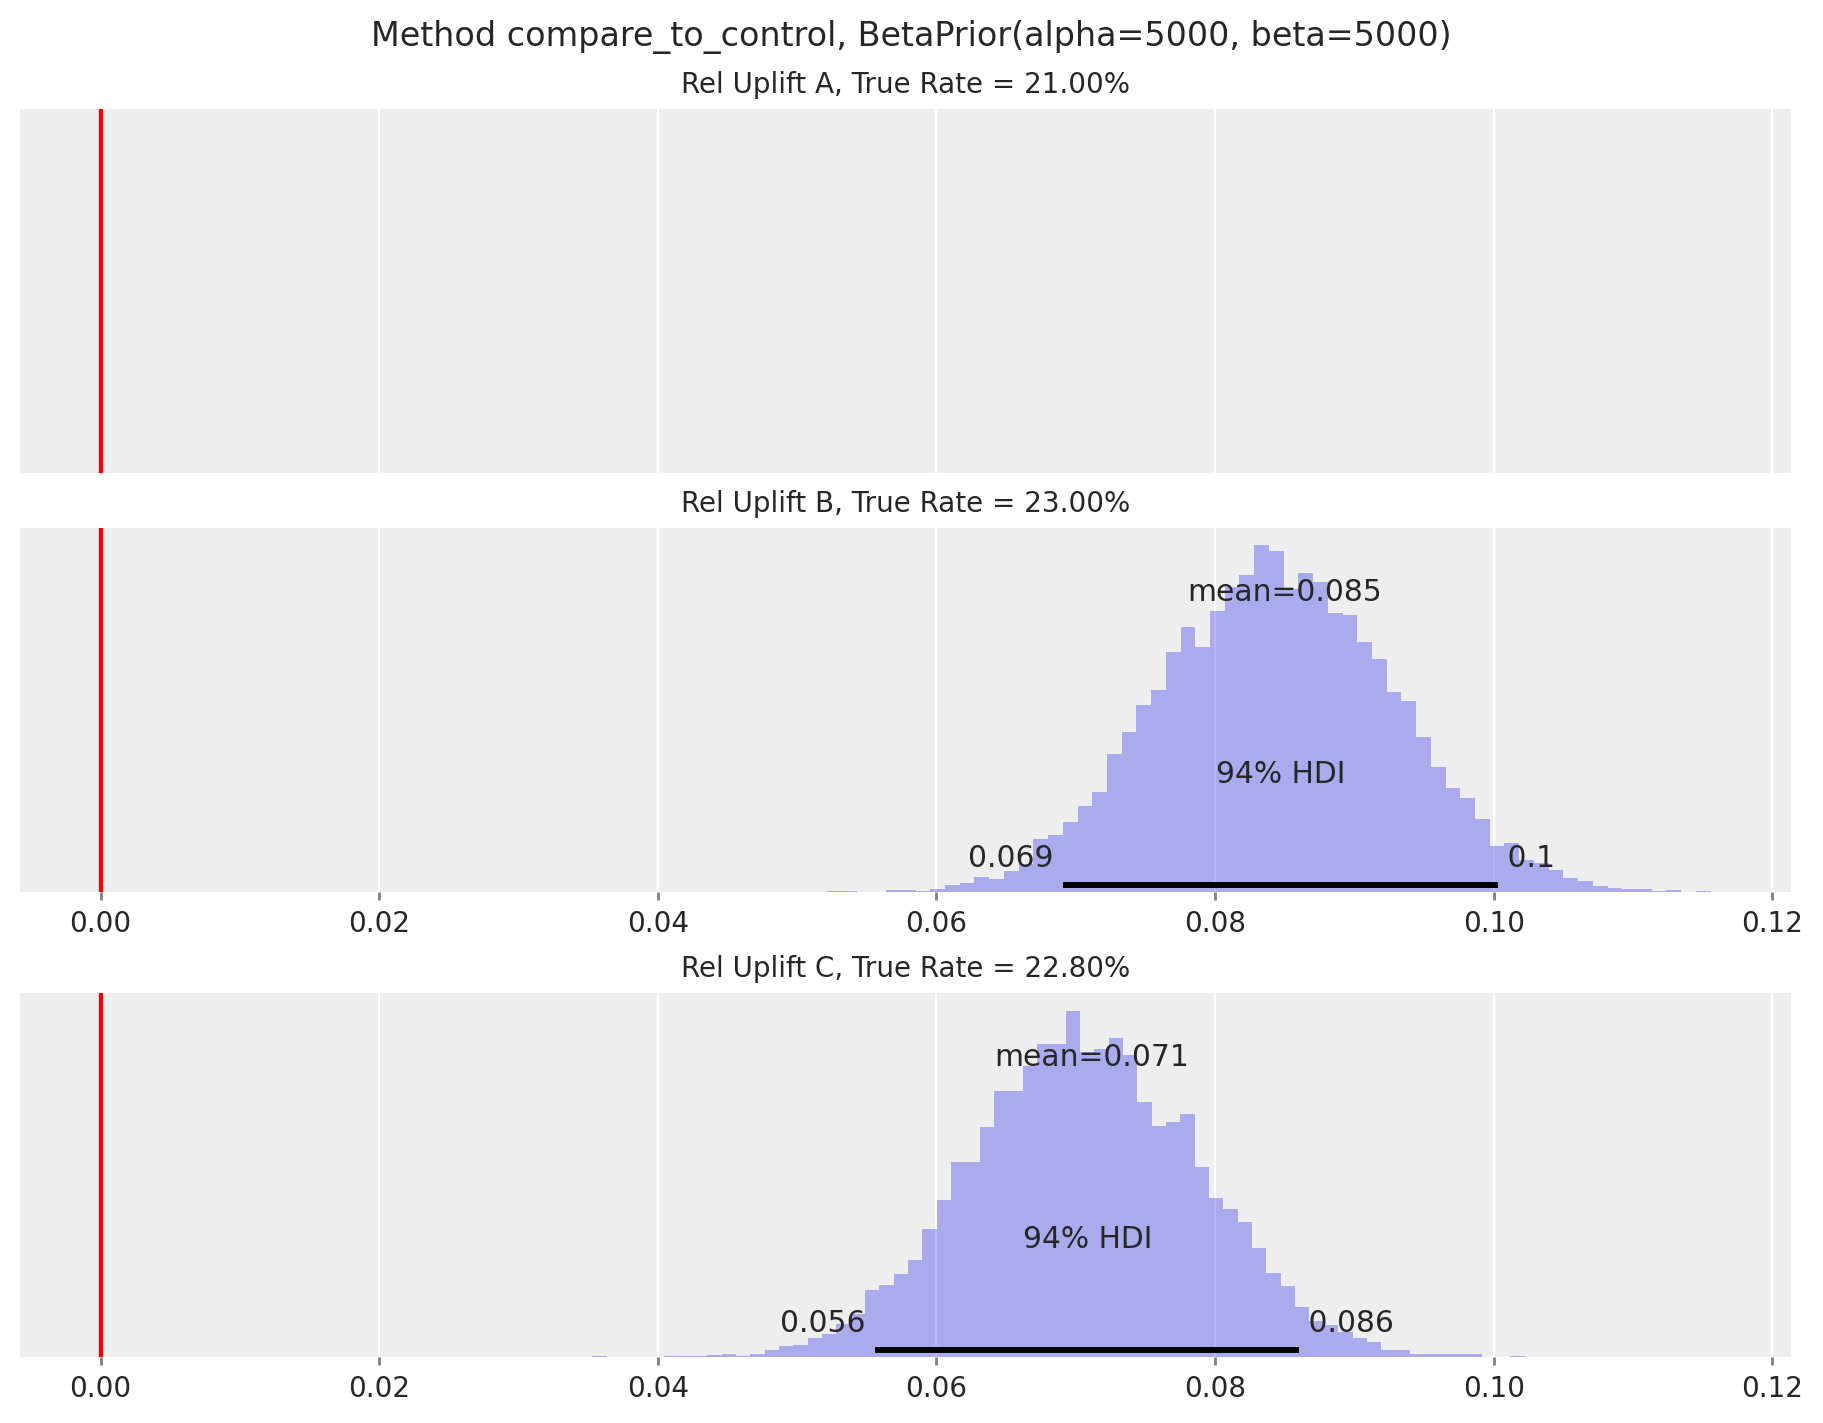

In [18]:
run_scenario_bernoulli(
    variants=["A", "B", "C"],
    true_rates=[0.21, 0.23, 0.228],
    samples_per_variant=100000,
    priors=BetaPrior(alpha=5000, beta=5000),
    comparison_method="compare_to_control",
)

* The relative uplift posteriors for both B and C show that they are clearly better than A (94% HDI well above 0), by roughly 7-8% relative.
* However, we can't infer whether there is a winner between B and C.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 5 seconds.


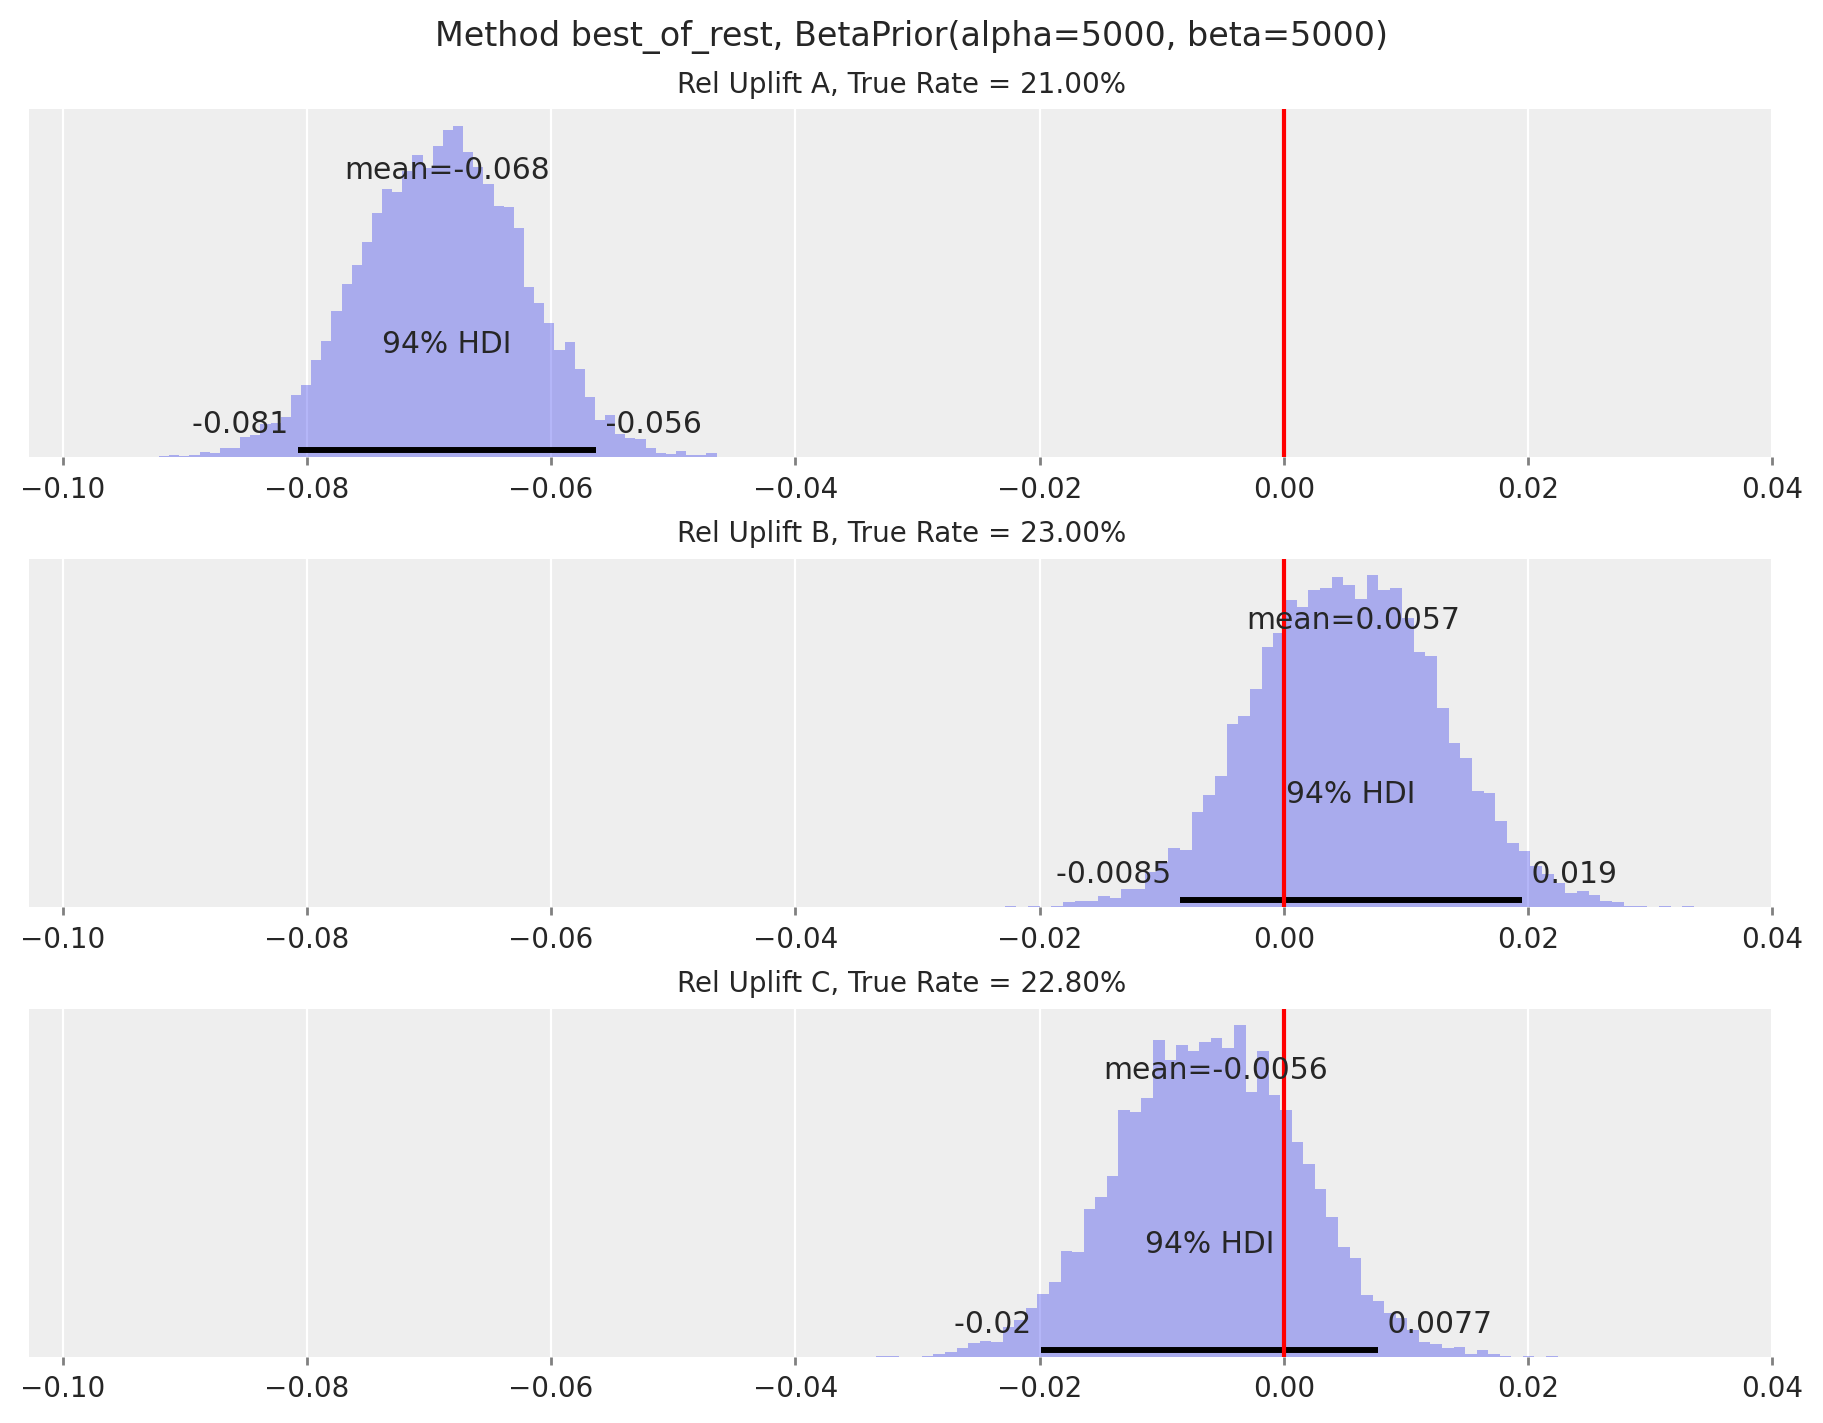

In [19]:
run_scenario_bernoulli(
    variants=["A", "B", "C"],
    true_rates=[0.21, 0.23, 0.228],
    samples_per_variant=100000,
    priors=BetaPrior(alpha=5000, beta=5000),
    comparison_method="best_of_rest",
)

* The uplift plot for A tells us that it's a clear loser compared to variants B and C (94% HDI for A's relative uplift is well below 0).
* Note that the relative uplift calculations for B and C are effectively ignoring variant A. This is because, say, when we are calculating `reluplift` for B, the maximum of the other variants will likely be variant C. Similarly when we are calculating `reluplift` for C, it is likely being compared to B.
* The uplift plots for B and C tell us that we can't yet call a clear winner between the two variants, as the 94% HDI still overlaps with 0. We'd need a larger sample size to detect the 23% vs 22.8% conversion rate difference.
* One disadvantage of this approach is that we can't directly say what the uplift of these variants is over the loser, variant A. This number is often important in practice, as it allows us to estimate the overall impact if the A/B test changes were rolled out to 100%. We _can_ get this number approximately though, by reframing the question to be "how much worse is A compared to the other two variants" (which is shown in Variant A's relative uplift distribution).

### Value Conversions

Now what if we wanted to compare A/B test variants in terms of how much revenue they generate, and/or estimate how much additional revenue a winning variant brings? We can't use a Beta-Binomial model for this, as the possible values for each visitor are now in the range `[0, Inf)`. The model proposed in the VWO paper is as follows:

The revenue generated by an individual visitor is `revenue = probability of paying at all * mean amount spent when paying`:

$$\mathrm{Revenue}_i = \mathrm{Bernoulli}(\theta)_i * \mathrm{Exponential}(\lambda)_i I(\mathrm{Bernoulli}(\theta)_i = 0)$$

We assume that the probability of paying at all is independent to the mean amount spent when paying. This is a typical assumption in practice, unless we have reason to believe that the two parameters are related. With this, we can create separate models for the total number of users paying, and the total amount spent amongst the purchasing visitors (assuming independence between the behaviour of each visitor):

$$c \sim \sum^N\mathrm{Bernoulli}(\theta) = \mathrm{Binomial}(N, \theta)$$

$$r \sim \sum^K\mathrm{Exponential}(\lambda) = \mathrm{Gamma}(K, \lambda)$$

where $N$ is the total number of visitors, $K$ is the total number of visitors with at least one purchase.

We can re-use our Beta-Binomial model from before to model the Bernoulli conversions. For the average amount spent per visitor, we use a Gamma prior (which is also a conjugate prior to the Gamma likelihood). So in a two-variant test, the setup is:

$$\theta_A \sim \theta_B \sim \mathrm{Beta}(\alpha_1, \beta_1)$$
$$\lambda_A \sim \lambda_B \sim \mathrm{Gamma}(\alpha_2, \beta_2)$$
$$c_A \sim \mathrm{Binomial}(N_A, \theta_A), c_B \sim \mathrm{Binomial}(N_B, \theta_B)$$
$$r_A \sim \mathrm{Gamma}(c_A, \lambda_A), r_B \sim \mathrm{Gamma}(c_B, \lambda_B)$$
$$\mu_A = \theta_A * \dfrac{1}{\lambda_A}, \mu_B = \theta_B * \dfrac{1}{\lambda_B}$$
$$\mathrm{reluplift}_B = \mu_B / \mu_A - 1$$

$\mu$ here represents the average revenue per visitor, including those who don't make a purchase. This is the best way to capture the overall revenue effect - some variants may increase the average sales value, but reduce the proportion of visitors that pay at all (e.g. if we promoted more expensive items on the landing page).

Below we put the model setup into code and perform prior predictive checks.

In [20]:
@dataclass
class GammaPrior:
    alpha: float
    beta: float

In [21]:
@dataclass
class RevenueData:
    visitors: int
    purchased: int
    total_revenue: float

In [22]:
class RevenueModel:
    def __init__(self, conversion_rate_prior: BetaPrior, mean_purchase_prior: GammaPrior):
        self.conversion_rate_prior = conversion_rate_prior
        self.mean_purchase_prior = mean_purchase_prior

    def create_model(self, data: List[RevenueData], comparison_method: str) -> pm.Model:
        num_variants = len(data)
        visitors = [d.visitors for d in data]
        purchased = [d.purchased for d in data]
        total_revenue = [d.total_revenue for d in data]

        with pm.Model() as model:
            theta = pm.Beta(
                "theta",
                alpha=self.conversion_rate_prior.alpha,
                beta=self.conversion_rate_prior.beta,
                shape=num_variants,
            )
            lam = pm.Gamma(
                "lam",
                alpha=self.mean_purchase_prior.alpha,
                beta=self.mean_purchase_prior.beta,
                shape=num_variants,
            )
            converted = pm.Binomial(
                "converted", n=visitors, p=theta, observed=purchased, shape=num_variants
            )
            revenue = pm.Gamma(
                "revenue", alpha=purchased, beta=lam, observed=total_revenue, shape=num_variants
            )
            revenue_per_visitor = pm.Deterministic("revenue_per_visitor", theta * (1 / lam))
            reluplift = []
            for i in range(num_variants):
                if comparison_method == "compare_to_control":
                    comparison = revenue_per_visitor[0]
                elif comparison_method == "best_of_rest":
                    others = [revenue_per_visitor[j] for j in range(num_variants) if j != i]
                    if len(others) > 1:
                        comparison = pmm.maximum(*others)
                    else:
                        comparison = others[0]
                else:
                    raise ValueError(f"comparison method {comparison_method} not recognised.")
                reluplift.append(
                    pm.Deterministic(f"reluplift_{i}", revenue_per_visitor[i] / comparison - 1)
                )
        return model

For the Beta prior, we can set a similar prior to before - centered around 0.5, with the magnitude of `alpha` and `beta` determining how "thin" the distribution.

We need to be a bit more careful about the Gamma prior. The mean of the Gamma prior is $\dfrac{\alpha_G}{\beta_G}$, and needs to be set to a reasonable value given existing mean purchase values. For example, if `alpha` and `beta` were set such that the mean was \\$1, but the average revenue per visitor for a website is much higher at \\$50, this could affect our inference.

In [23]:
c_prior = BetaPrior(alpha=5000, beta=5000)
mp_prior = GammaPrior(alpha=10000, beta=500)

In [24]:
data = [
    RevenueData(visitors=1, purchased=1, total_revenue=1),
    RevenueData(visitors=1, purchased=1, total_revenue=1),
]

In [25]:
with RevenueModel(c_prior, mp_prior).create_model(data, "best_of_rest"):
    revenue_prior_predictive = pm.sample_prior_predictive(samples=10000)

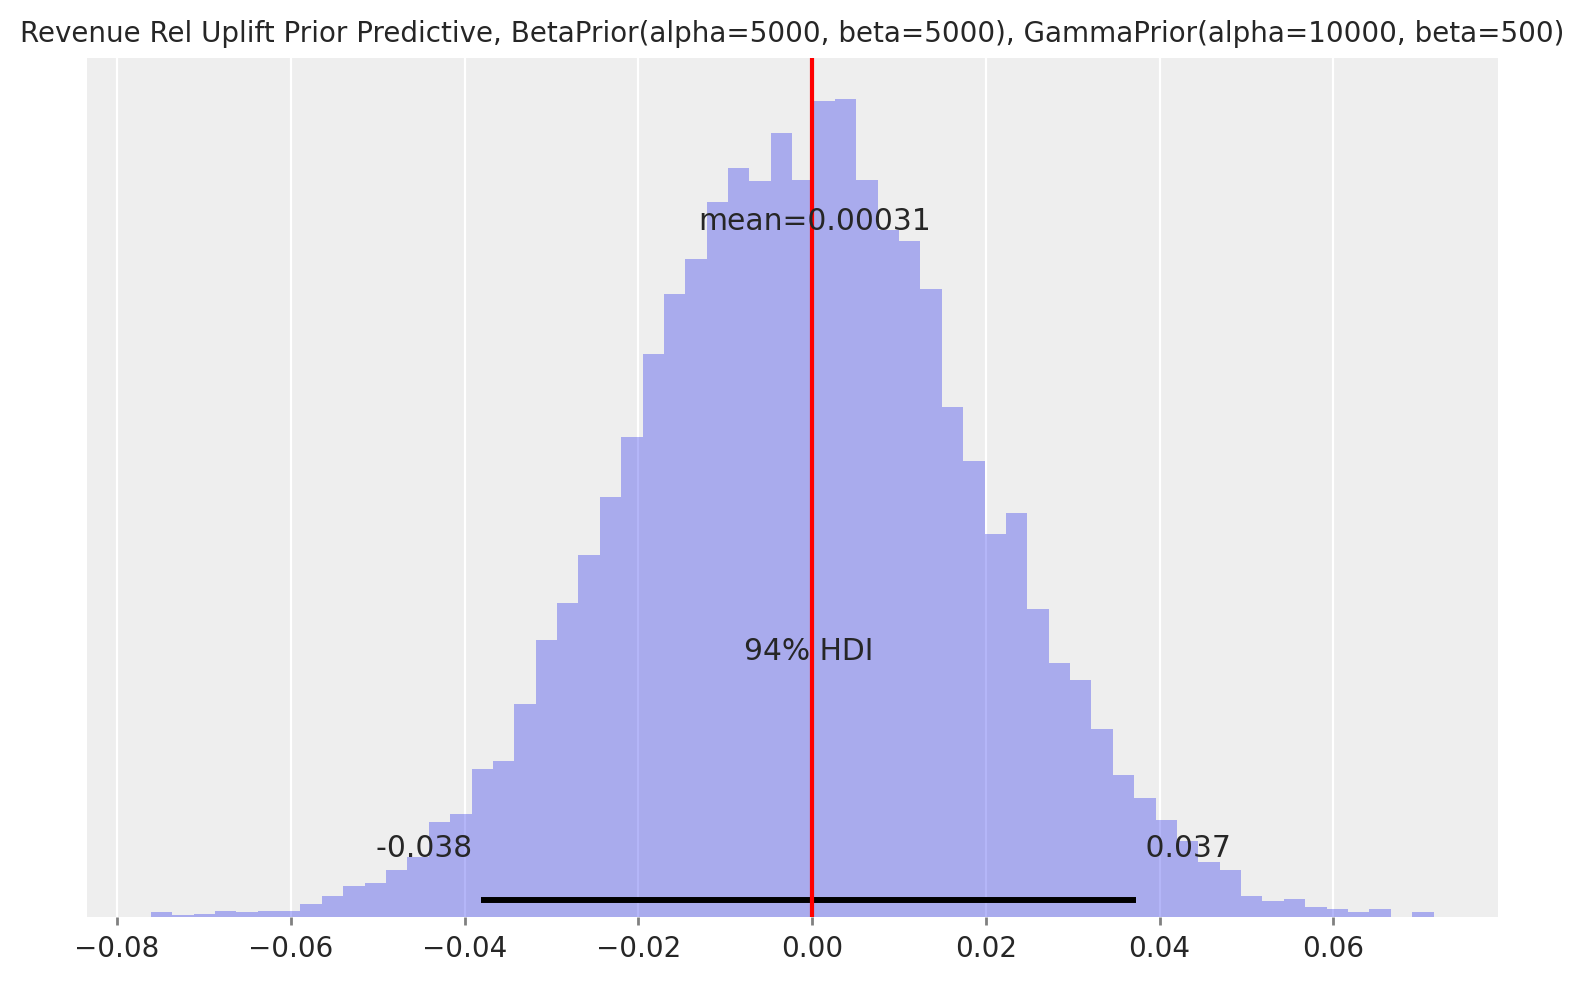

In [26]:
fig, ax = plt.subplots()
az.plot_posterior(revenue_prior_predictive["reluplift_1"], textsize=10, ax=ax, kind="hist")
ax.set_title(f"Revenue Rel Uplift Prior Predictive, {c_prior}, {mp_prior}", fontsize=10)
ax.axvline(x=0, color="red")

Similar to the model for Bernoulli conversions, the width of the prior predictive uplift distribution will depend on the strength of our priors. See the Bernoulli conversions section for a discussion of the benefits and disadvantages of using a weak vs. strong prior.

Next we generate synthetic data for the model. We'll generate the following scenarios:

* Same propensity to purchase and same mean purchase value.
* Lower propensity to purchase and higher mean purchase value, but overall same revenue per visitor.
* Higher propensity to purchase and higher mean purchase value, and overall higher revenue per visitor.

In [27]:
def generate_revenue_data(
    variants: List[str],
    true_conversion_rates: List[float],
    true_mean_purchase: List[float],
    samples_per_variant: int,
) -> pd.DataFrame:
    converted = {}
    mean_purchase = {}
    for variant, p, mp in zip(variants, true_conversion_rates, true_mean_purchase):
        converted[variant] = bernoulli.rvs(p, size=samples_per_variant)
        mean_purchase[variant] = expon.rvs(scale=mp, size=samples_per_variant)
    converted = pd.DataFrame(converted)
    mean_purchase = pd.DataFrame(mean_purchase)
    revenue = converted * mean_purchase
    agg = pd.concat(
        [
            converted.aggregate(["count", "sum"]).rename(
                index={"count": "visitors", "sum": "purchased"}
            ),
            revenue.aggregate(["sum"]).rename(index={"sum": "total_revenue"}),
        ]
    )
    return agg

In [28]:
def run_scenario_value(
    variants: List[str],
    true_conversion_rates: List[float],
    true_mean_purchase: List[float],
    samples_per_variant: int,
    conversion_rate_prior: BetaPrior,
    mean_purchase_prior: GammaPrior,
    comparison_method: str,
) -> None:
    generated = generate_revenue_data(
        variants, true_conversion_rates, true_mean_purchase, samples_per_variant
    )
    data = [RevenueData(**generated[v].to_dict()) for v in variants]
    with RevenueModel(conversion_rate_prior, mean_purchase_prior).create_model(
        data, comparison_method
    ):
        trace = pm.sample(draws=5000, return_inferencedata=True, chains=2, cores=1)

    n_plots = len(variants)
    fig, axs = plt.subplots(nrows=n_plots, ncols=1, figsize=(3 * n_plots, 7), sharex=True)
    for i, variant in enumerate(variants):
        if i == 0 and comparison_method == "compare_to_control":
            axs[i].set_yticks([])
        else:
            az.plot_posterior(
                trace.posterior[f"reluplift_{i}"], textsize=10, ax=axs[i], kind="hist"
            )
        true_rpv = true_conversion_rates[i] * true_mean_purchase[i]
        axs[i].set_title(f"Rel Uplift {variant}, True RPV = {true_rpv:.2f}", fontsize=10)
        axs[i].axvline(x=0, color="red")
    fig.suptitle(f"Method {comparison_method}, {conversion_rate_prior}, {mean_purchase_prior}")

#### Scenario 1 - same underlying purchase rate and mean purchase value

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 6 seconds.


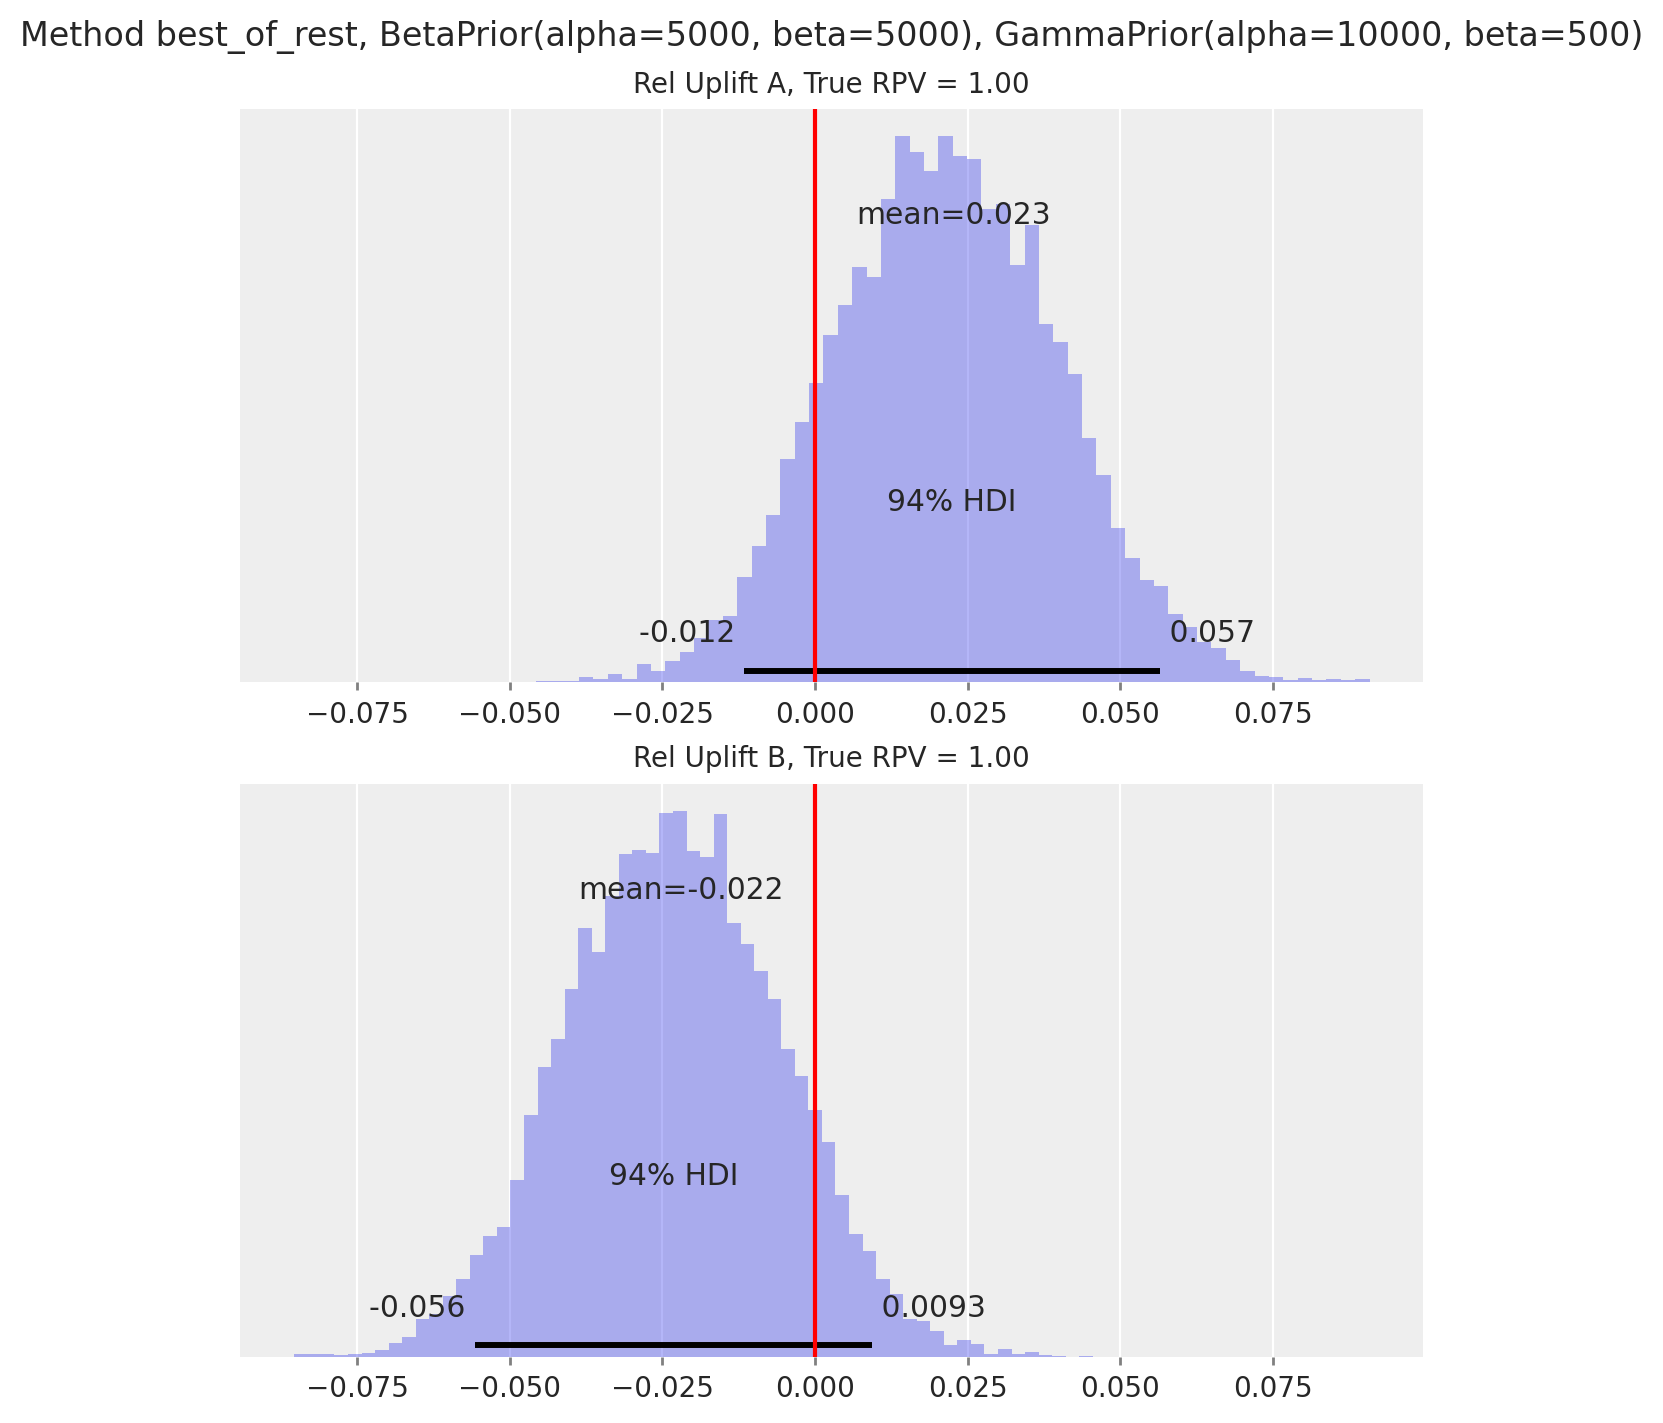

In [29]:
run_scenario_value(
    variants=["A", "B"],
    true_conversion_rates=[0.05, 0.05],
    true_mean_purchase=[20, 20],
    samples_per_variant=100000,
    conversion_rate_prior=BetaPrior(alpha=5000, beta=5000),
    mean_purchase_prior=GammaPrior(alpha=10000, beta=500),
    comparison_method="best_of_rest",
)

* The 94% HDI contains 0 as expected.

#### Scenario 2 - lower purchase rate, higher mean purchase, same overall revenue per visitor

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 6 seconds.


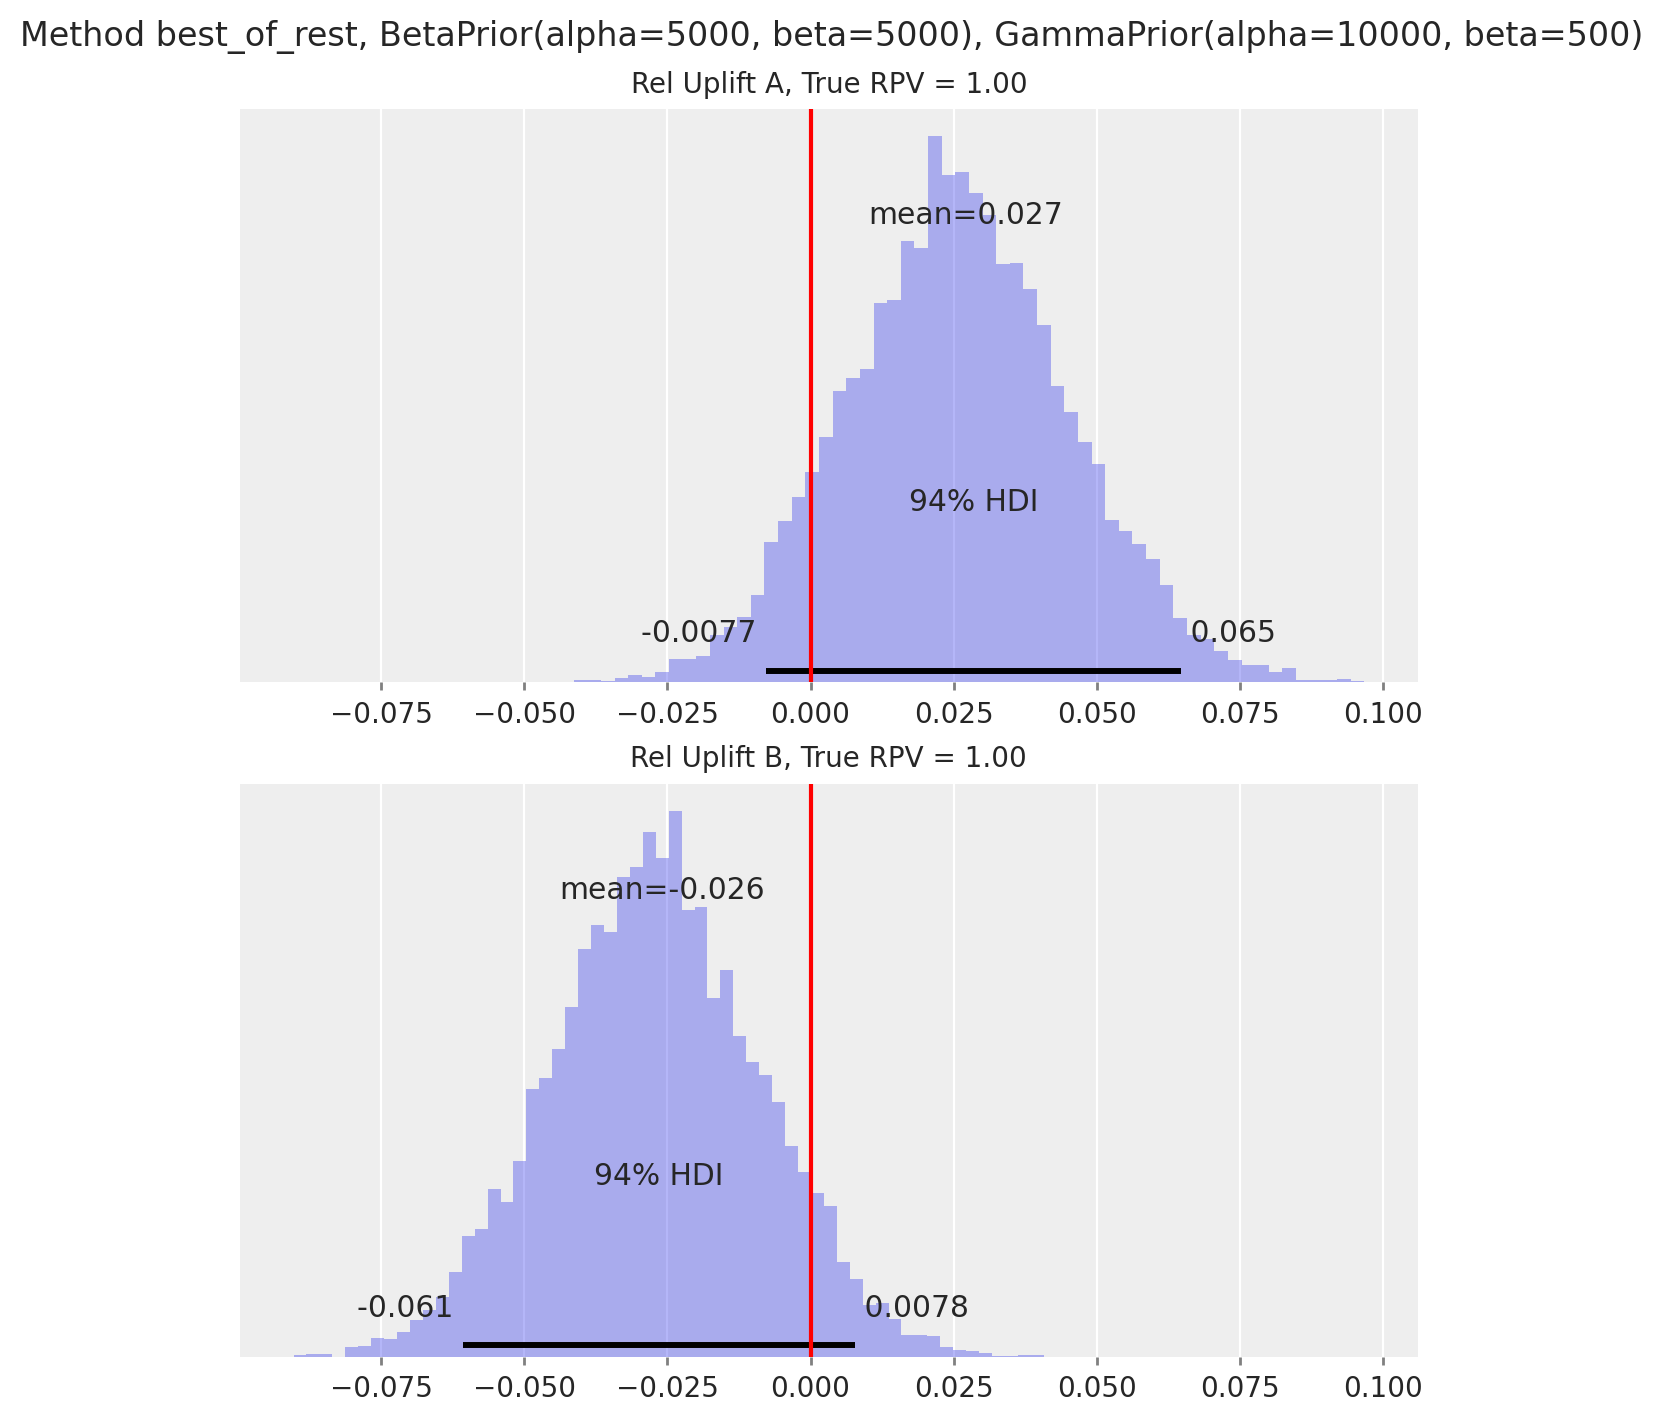

In [30]:
run_scenario_value(
    variants=["A", "B"],
    true_conversion_rates=[0.05, 0.04],
    true_mean_purchase=[20, 25],
    samples_per_variant=100000,
    conversion_rate_prior=BetaPrior(alpha=5000, beta=5000),
    mean_purchase_prior=GammaPrior(alpha=10000, beta=500),
    comparison_method="best_of_rest",
)

* The 94% HDI for the average revenue per visitor (RPV) contains 0 as expected.
* In these cases, it's also useful to plot the relative uplift distributions for `theta` (the purchase-anything rate) and `1 / lam` (the mean purchase value) to understand how the A/B test has affected visitor behaviour.

#### Scenario 3 - Higher propensity to purchase and mean purchase value

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lam, theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.8835308501440228, but should be close to 0.8. Try to increase the number of tuning steps.


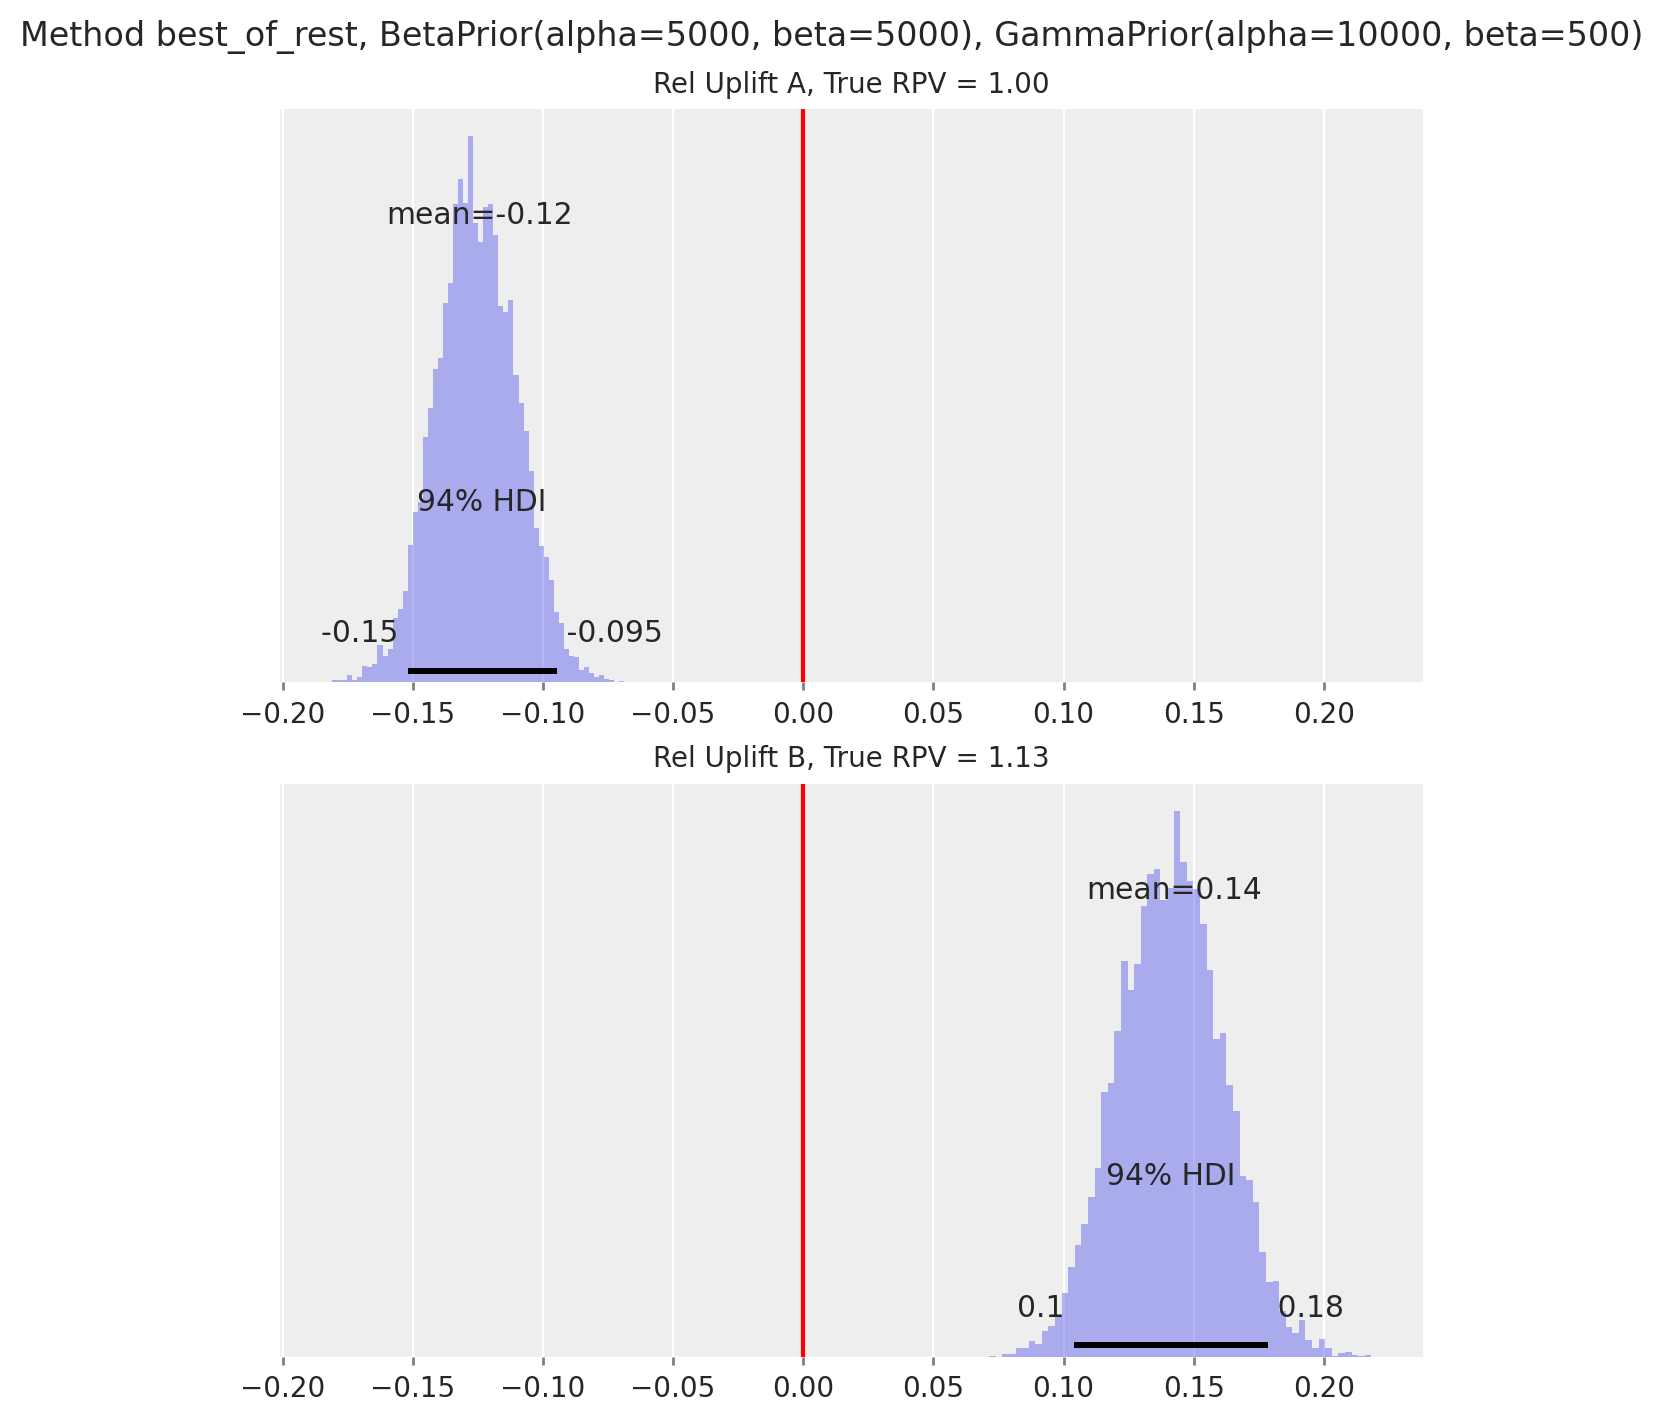

In [31]:
run_scenario_value(
    variants=["A", "B"],
    true_conversion_rates=[0.05, 0.055],
    true_mean_purchase=[20, 20.5],
    samples_per_variant=100000,
    conversion_rate_prior=BetaPrior(alpha=5000, beta=5000),
    mean_purchase_prior=GammaPrior(alpha=10000, beta=500),
    comparison_method="best_of_rest",
)

* The 94% HDI is above 0 for variant B as expected.

Note that one concern with using value conversions in practice (that doesn't show up when we're just simulating synthetic data) is the existence of outliers. For example, a visitor in a variant could spend thousands of dollars, and the observed revenue data no longer follows a 'nice' distribution like Gamma. It's common to impute these outliers prior to running a statistical analysis (we have to be careful with removing them altogether, as this could bias the inference), or fall back to bernoulli conversions for decision making.

### Further Reading

There are many other considerations to implementing a Bayesian framework to analyse A/B tests in practice. Some include:

* How do we choose our prior distributions? 
* In practice, people look at A/B test results every day, not only once at the end of the test. How do we balance finding true differences faster vs. minizing false discoveries (the 'early stopping' problem)?
* How do we plan the length and size of A/B tests using power analysis, if we're using Bayesian models to analyse the results?
* Outside of the conversion rates (bernoulli random variables for each visitor), many value distributions in online software cannot be fit with nice densities like Normal, Gamma, etc. How do we model these?

Various textbooks and online resources dive into these areas in more detail. [Doing Bayesian Data Analysis](http://doingbayesiandataanalysis.blogspot.com/) by John Kruschke is a great resource, and has been translated to PyMC3 here: https://github.com/JWarmenhoven/DBDA-python.

We also plan to create more PyMC3 tutorials on these topics, so stay tuned!

---

**Author: Cuong Duong (2021-05-23)**

### References

* [Stucchio, C. _Bayesian A/B Testing at VWO_ (2015)](https://vwo.com/downloads/VWO_SmartStats_technical_whitepaper.pdf)

In [32]:
%load_ext watermark
%watermark -n -u -v -iv -w -p theano,xarray

Last updated: Tue May 25 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.23.1

theano: 1.1.2
xarray: 0.18.0

pymc3     : 3.11.2
matplotlib: 3.4.2
numpy     : 1.20.3
arviz     : 0.11.2
pandas    : 1.2.4

Watermark: 2.2.0

